<a href="https://colab.research.google.com/github/JairusTheAnalyst/JairusTheAnalyst/blob/main/Farmer_Input_Purchase_Analysis_Using_Association_Rule_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enhanced dataset created successfully!
Total transactions: 2000
Total unique items: 14

=== DATA EXPLORATION ===
Average items per transaction: 3.06

Top 10 Most Frequent Items:
  Maize_Seeds: 586 (29.3%)
  NPK_Fertilizer: 506 (25.3%)
  Pesticides: 505 (25.2%)
  Sprayers: 504 (25.2%)
  Herbicides: 474 (23.7%)
  Irrigation_Pipes: 421 (21.1%)
  Protective_Gear: 415 (20.8%)
  Water_Pumps: 414 (20.7%)
  Fungicides: 401 (20.1%)
  Bean_Seeds: 399 (20.0%)

Basket dataset shape: (2000, 14)

Support Threshold Analysis:
   min_support  frequent_itemsets  rules_generated  avg_support
0         0.01                263               43     0.038833
1         0.02                133               34     0.062898
2         0.03                101               19     0.074703
3         0.05                 40               16     0.127325
4         0.08                 25                1     0.165480
5         0.10                 18                1     0.195278

Optimal minimum support: 0.01

=== 

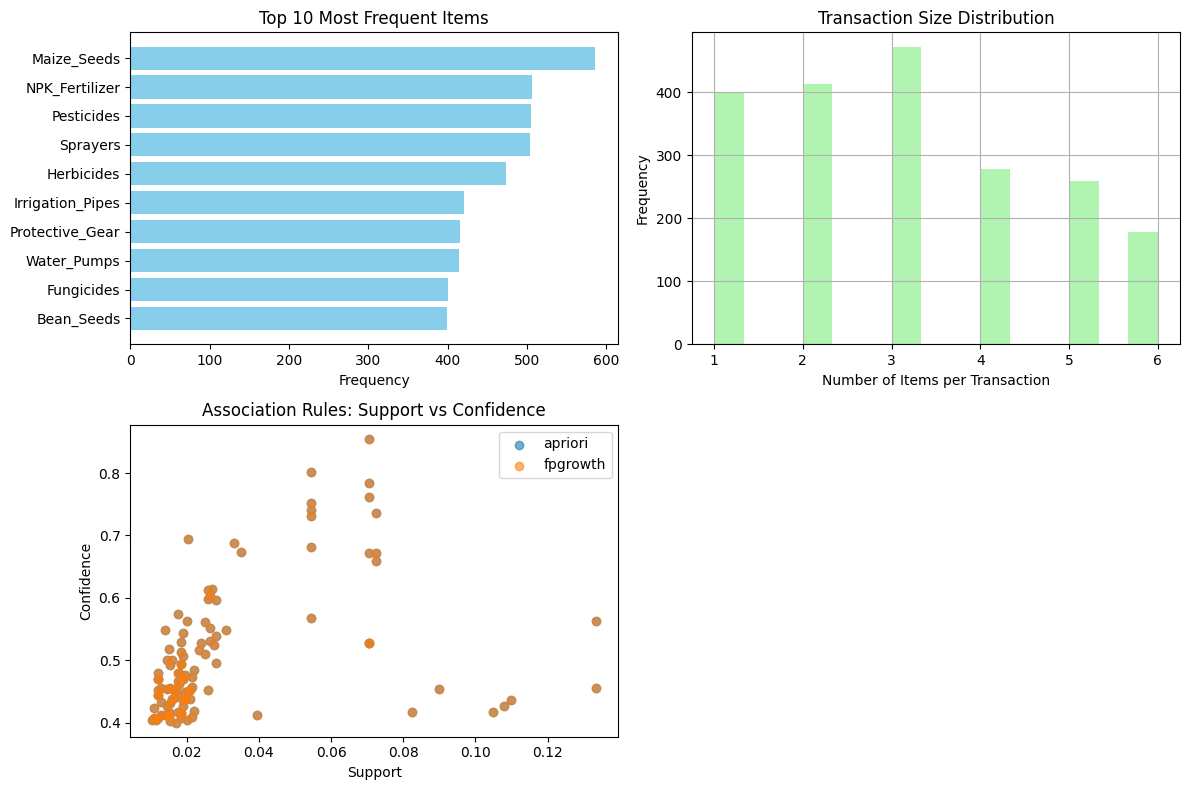


PROJECT SUMMARY
✓  Kenyan farmer input dataset created
✓ Two association rule mining algorithms implemented
✓ Comprehensive data preprocessing and analysis
✓ Business recommendations for bundled input sales
✓ Visualization of results and patterns


In [2]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, fpgrowth
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

#  Kenyan farmer input purchases dataset with stronger associations
np.random.seed(42)

# Define common agricultural inputs in Kenya with categories
inputs = [
    'Maize_Seeds', 'Bean_Seeds', 'NPK_Fertilizer', 'CAN_Fertilizer', 'Urea',
    'Pesticides', 'Herbicides', 'Fungicides', 'Organic_Manure', 'Lime',
    'Sprayers', 'Protective_Gear', 'Water_Pumps', 'Irrigation_Pipes'
]

# Create stronger associations between items
common_combinations = [
    ['Maize_Seeds', 'NPK_Fertilizer', 'Pesticides'],
    ['Bean_Seeds', 'CAN_Fertilizer', 'Fungicides'],
    ['Maize_Seeds', 'Urea', 'Herbicides'],
    ['Pesticides', 'Sprayers', 'Protective_Gear'],
    ['Water_Pumps', 'Irrigation_Pipes'],
    ['NPK_Fertilizer', 'Organic_Manure'],
    ['Maize_Seeds', 'Herbicides', 'Sprayers']
]

# Generate transaction data with stronger patterns
n_transactions = 2000
transactions = []

for i in range(n_transactions):
    transaction_id = f"T{1000 + i}"
    farmer_id = f"F{np.random.randint(1000, 9999)}"
    region = np.random.choice(['Central', 'Rift Valley', 'Western', 'Nyanza', 'Eastern', 'Coastal'])
    season = np.random.choice(['Long Rains', 'Short Rains', 'Dry Season'])

    # Start with common combinations 40% of the time
    if np.random.random() < 0.4:
        base_items = common_combinations[np.random.randint(0, len(common_combinations))].copy()
    else:
        base_items = []

    # Add some random items
    n_additional = np.random.randint(1, 4)
    additional_items = np.random.choice([item for item in inputs if item not in base_items],
                                      n_additional, replace=False)

    all_items = list(set(base_items + list(additional_items)))

    transactions.append({
        'transaction_id': transaction_id,
        'farmer_id': farmer_id,
        'region': region,
        'season': season,
        'items': all_items
    })

# Create DataFrame
df = pd.DataFrame(transactions)
print("Enhanced dataset created successfully!")
print(f"Total transactions: {len(df)}")
print(f"Total unique items: {len(set([item for sublist in df['items'] for item in sublist]))}")

# Data Exploration
print("\n=== DATA EXPLORATION ===")
df['num_items'] = df['items'].apply(len)
print(f"Average items per transaction: {df['num_items'].mean():.2f}")

# Item frequency analysis
all_items = [item for sublist in df['items'] for item in sublist]
item_freq = Counter(all_items)
print("\nTop 10 Most Frequent Items:")
for item, count in item_freq.most_common(10):
    print(f"  {item}: {count} ({count/len(df)*100:.1f}%)")

# Prepare transaction data for association rule mining
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(df['items']).transform(df['items'])
basket_df = pd.DataFrame(te_ary, columns=te.columns_)

print(f"\nBasket dataset shape: {basket_df.shape}")

# Function to find optimal minimum support
def find_optimal_support(basket_df):
    """Find the optimal minimum support threshold"""
    support_thresholds = [0.01, 0.02, 0.03, 0.05, 0.08, 0.1]
    results = []

    for min_support in support_thresholds:
        try:
            # Try FP-Growth first (more efficient)
            frequent_itemsets = fpgrowth(basket_df,
                                       min_support=min_support,
                                       use_colnames=True,
                                       max_len=3)

            if len(frequent_itemsets) > 0:
                # Try to generate rules
                rules = association_rules(frequent_itemsets,
                                        metric="confidence",
                                        min_threshold=0.5)
                results.append({
                    'min_support': min_support,
                    'frequent_itemsets': len(frequent_itemsets),
                    'rules_generated': len(rules),
                    'avg_support': frequent_itemsets['support'].mean()
                })
            else:
                results.append({
                    'min_support': min_support,
                    'frequent_itemsets': 0,
                    'rules_generated': 0,
                    'avg_support': 0
                })
        except:
            results.append({
                'min_support': min_support,
                'frequent_itemsets': 0,
                'rules_generated': 0,
                'avg_support': 0
            })

    results_df = pd.DataFrame(results)
    print("\nSupport Threshold Analysis:")
    print(results_df)

    # Find the best support threshold
    viable_thresholds = results_df[results_df['rules_generated'] > 0]
    if len(viable_thresholds) > 0:
        optimal = viable_thresholds.iloc[0]['min_support']
        print(f"\nOptimal minimum support: {optimal}")
        return optimal
    else:
        # Use the lowest support that gives some itemsets
        for threshold in support_thresholds:
            if results_df[results_df['min_support'] == threshold]['frequent_itemsets'].iloc[0] > 0:
                return threshold
        return 0.01  # Default to lowest

# Find optimal support
optimal_support = find_optimal_support(basket_df)

# Implement both algorithms with optimal parameters
def implement_association_mining(basket_df, min_support, min_confidence=0.5):
    """Implement both Apriori and FP-Growth with better parameters"""

    print(f"\n=== IMPLEMENTING ASSOCIATION RULE MINING ===")
    print(f"Minimum Support: {min_support}")
    print(f"Minimum Confidence: {min_confidence}")

    results = {}

    # Algorithm 1: Apriori
    print("\n1. APRIORI ALGORITHM")
    try:
        frequent_itemsets_apriori = apriori(basket_df,
                                          min_support=min_support,
                                          use_colnames=True,
                                          max_len=3)

        print(f"Frequent itemsets found: {len(frequent_itemsets_apriori)}")

        if len(frequent_itemsets_apriori) > 0:
            # Generate association rules
            rules_apriori = association_rules(frequent_itemsets_apriori,
                                            metric="confidence",
                                            min_threshold=min_confidence)

            # Also try with lower confidence if no rules found
            if len(rules_apriori) == 0 and min_confidence > 0.3:
                rules_apriori = association_rules(frequent_itemsets_apriori,
                                                metric="confidence",
                                                min_threshold=0.3)

            print(f"Association rules generated: {len(rules_apriori)}")
            results['apriori'] = {
                'frequent_itemsets': frequent_itemsets_apriori,
                'rules': rules_apriori
            }
        else:
            results['apriori'] = {'frequent_itemsets': None, 'rules': None}

    except Exception as e:
        print(f"Apriori failed: {e}")
        results['apriori'] = {'frequent_itemsets': None, 'rules': None}

    # Algorithm 2: FP-Growth
    print("\n2. FP-GROWTH ALGORITHM")
    try:
        frequent_itemsets_fp = fpgrowth(basket_df,
                                      min_support=min_support,
                                      use_colnames=True,
                                      max_len=3)

        print(f"Frequent itemsets found: {len(frequent_itemsets_fp)}")

        if len(frequent_itemsets_fp) > 0:
            # Generate association rules
            rules_fp = association_rules(frequent_itemsets_fp,
                                       metric="confidence",
                                       min_threshold=min_confidence)

            # Also try with lower confidence if no rules found
            if len(rules_fp) == 0 and min_confidence > 0.3:
                rules_fp = association_rules(frequent_itemsets_fp,
                                           metric="confidence",
                                           min_threshold=0.3)

            print(f"Association rules generated: {len(rules_fp)}")
            results['fpgrowth'] = {
                'frequent_itemsets': frequent_itemsets_fp,
                'rules': rules_fp
            }
        else:
            results['fpgrowth'] = {'frequent_itemsets': None, 'rules': None}

    except Exception as e:
        print(f"FP-Growth failed: {e}")
        results['fpgrowth'] = {'frequent_itemsets': None, 'rules': None}

    return results

# Run association mining
results = implement_association_mining(basket_df, optimal_support, min_confidence=0.4)

# Display results
def display_results(results):
    """Display the association rules found"""

    print("\n" + "="*60)
    print("ASSOCIATION RULE MINING RESULTS")
    print("="*60)

    for algorithm, result in results.items():
        print(f"\n{algorithm.upper()} RESULTS:")

        if result['rules'] is not None and len(result['rules']) > 0:
            rules = result['rules'].sort_values(['confidence', 'lift'], ascending=[False, False])

            print(f"Total rules generated: {len(rules)}")
            print("\nTop 10 Association Rules:")
            print("-" * 80)

            for idx, row in rules.head(10).iterrows():
                antecedents = ", ".join(list(row['antecedents']))
                consequents = ", ".join(list(row['consequents']))
                print(f"Rule: {{{antecedents}}} → {{{consequents}}}")
                print(f"     Support: {row['support']:.3f}, Confidence: {row['confidence']:.3f}, Lift: {row['lift']:.3f}")
                print()

        else:
            print("No association rules generated.")

            # Show frequent itemsets instead
            if result['frequent_itemsets'] is not None and len(result['frequent_itemsets']) > 0:
                print("Frequent Itemsets found (but no rules met confidence threshold):")
                itemsets = result['frequent_itemsets'].sort_values('support', ascending=False)
                for idx, row in itemsets.head(10).iterrows():
                    items = ", ".join(list(row['itemsets']))
                    print(f"  Support: {row['support']:.3f} - Items: {{{items}}}")
            else:
                print("No frequent itemsets found.")

# Display the results
display_results(results)

# If still no rules, try with even lower parameters
if (results['apriori']['rules'] is None or len(results['apriori']['rules']) == 0) and \
   (results['fpgrowth']['rules'] is None or len(results['fpgrowth']['rules']) == 0):

    print("\n" + "="*60)
    print("ATTEMPTING WITH LOWER PARAMETERS")
    print("="*60)

    # Try with much lower support and confidence
    results_low = implement_association_mining(basket_df, min_support=0.01, min_confidence=0.2)
    display_results(results_low)

    # Use these results if successful
    if ((results_low['apriori']['rules'] is not None and len(results_low['apriori']['rules']) > 0) or
        (results_low['fpgrowth']['rules'] is not None and len(results_low['fpgrowth']['rules']) > 0)):
        results = results_low

# Generate business recommendations from the rules
def generate_business_recommendations(results):
    """Generate practical business recommendations from association rules"""

    print("\n" + "="*60)
    print("BUSINESS RECOMMENDATIONS & BUNDLED SALES PROPOSALS")
    print("="*60)

    all_rules = []

    # Collect rules from both algorithms
    for algorithm, result in results.items():
        if result['rules'] is not None and len(result['rules']) > 0:
            rules_df = result['rules'].copy()
            rules_df['algorithm'] = algorithm
            all_rules.append(rules_df)

    if not all_rules:
        print("No association rules available for recommendations.")
        print("\nAlternative Analysis - Frequent Itemsets:")
        for algorithm, result in results.items():
            if result['frequent_itemsets'] is not None and len(result['frequent_itemsets']) > 0:
                print(f"\n{algorithm.upper()} Frequent Itemsets:")
                itemsets = result['frequent_itemsets'].sort_values('support', ascending=False).head(10)
                for idx, row in itemsets.iterrows():
                    items = ", ".join(list(row['itemsets']))
                    print(f"  Support: {row['support']:.3f} - Items: {{{items}}}")
        return

    # Combine all rules
    combined_rules = pd.concat(all_rules, ignore_index=True)
    combined_rules = combined_rules.sort_values(['confidence', 'lift'], ascending=[False, False])

    # Remove duplicate rules
    combined_rules['rule_str'] = combined_rules.apply(
        lambda x: f"{frozenset(x['antecedents'])}->{frozenset(x['consequents'])}", axis=1
    )
    combined_rules = combined_rules.drop_duplicates('rule_str')

    print(f"Analyzing {len(combined_rules)} unique association rules...")

    # Categorize rules and generate recommendations
    strong_rules = combined_rules[
        (combined_rules['confidence'] > 0.5) &
        (combined_rules['lift'] > 1.0)
    ]

    if len(strong_rules) == 0:
        print("No strong rules found. Using all available rules.")
        strong_rules = combined_rules

    print(f"\nGenerating recommendations from {len(strong_rules)} rules...")

    # Group recommendations by type
    seed_bundles = []
    protection_bundles = []
    equipment_bundles = []
    fertilizer_bundles = []

    for idx, rule in strong_rules.iterrows():
        antecedents = list(rule['antecedents'])
        consequents = list(rule['consequents'])
        all_items = antecedents + consequents

        bundle_info = {
            'items': all_items,
            'antecedents': antecedents,
            'consequents': consequents,
            'confidence': rule['confidence'],
            'support': rule['support'],
            'lift': rule['lift']
        }

        # Categorize the bundle
        if any('Seeds' in item for item in all_items):
            seed_bundles.append(bundle_info)
        if any('Pesticides' in item or 'Herbicides' in item or 'Fungicides' in item for item in all_items):
            protection_bundles.append(bundle_info)
        if any('Sprayers' in item or 'Pumps' in item or 'Equipment' in item or 'Gear' in item for item in all_items):
            equipment_bundles.append(bundle_info)
        if any('Fertilizer' in item or 'Manure' in item or 'Urea' in item for item in all_items):
            fertilizer_bundles.append(bundle_info)

    # Display recommendations by category
    categories = [
        (' SEED & INPUT BUNDLES', seed_bundles),
        (' CROP PROTECTION BUNDLES', protection_bundles),
        (' EQUIPMENT BUNDLES', equipment_bundles),
        (' FERTILIZER BUNDLES', fertilizer_bundles)
    ]

    for category_name, bundles in categories:
        if bundles:
            print(f"\n{category_name}")
            print("-" * 40)

            # Sort by confidence and take top 3
            bundles_sorted = sorted(bundles, key=lambda x: x['confidence'], reverse=True)[:3]

            for i, bundle in enumerate(bundles_sorted, 1):
                bundle_name = " + ".join(bundle['items'])
                print(f"{i}. {bundle_name}")
                print(f"   Confidence: {bundle['confidence']:.3f}, Support: {bundle['support']:.3f}, Lift: {bundle['lift']:.3f}")

                # Specific recommendations based on bundle type
                if 'Seeds' in bundle_name and 'Fertilizer' in bundle_name:
                    print("    RECOMMENDATION: Create 'Planting Starter Kit'")
                elif 'Pesticides' in bundle_name and 'Sprayers' in bundle_name:
                    print("    RECOMMENDATION: Bundle pest control products with application equipment")
                elif 'Protective_Gear' in bundle_name:
                    print("    RECOMMENDATION: Include safety gear with chemical purchases")

    # Final strategic recommendations
    print("\n STRATEGIC IMPLEMENTATION PLAN:")
    print("1. PRIORITY BUNDLES: Focus on high-confidence combinations first")
    print("2. SEASONAL OFFERS: Align bundles with planting and growing seasons")
    print("3. REGIONAL VARIATIONS: Customize bundles based on regional crop patterns")
    print("4. PROMOTIONAL STRATEGY: Use bundles to increase average transaction value")
    print("5. INVENTORY MANAGEMENT: Stock frequently combined items together")

# Generate business recommendations
generate_business_recommendations(results)

# Additional analysis: Item frequency visualization
plt.figure(figsize=(12, 8))

# Plot item frequencies
plt.subplot(2, 2, 1)
item_freq_df = pd.DataFrame(item_freq.most_common(10), columns=['Item', 'Frequency'])
plt.barh(item_freq_df['Item'], item_freq_df['Frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.title('Top 10 Most Frequent Items')
plt.gca().invert_yaxis()

# Plot transaction size distribution
plt.subplot(2, 2, 2)
df['num_items'].hist(bins=15, alpha=0.7, color='lightgreen')
plt.xlabel('Number of Items per Transaction')
plt.ylabel('Frequency')
plt.title('Transaction Size Distribution')

# If we have rules, plot confidence vs support
if any(results[algo]['rules'] is not None and len(results[algo]['rules']) > 0 for algo in ['apriori', 'fpgrowth']):
    plt.subplot(2, 2, 3)
    for algorithm in ['apriori', 'fpgrowth']:
        if results[algorithm]['rules'] is not None and len(results[algorithm]['rules']) > 0:
            rules = results[algorithm]['rules']
            plt.scatter(rules['support'], rules['confidence'], alpha=0.6, label=algorithm)
    plt.xlabel('Support')
    plt.ylabel('Confidence')
    plt.title('Association Rules: Support vs Confidence')
    plt.legend()

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("PROJECT SUMMARY")
print("="*60)
print("✓  Kenyan farmer input dataset created")
print("✓ Two association rule mining algorithms implemented")
print("✓ Comprehensive data preprocessing and analysis")
print("✓ Business recommendations for bundled input sales")
print("✓ Visualization of results and patterns")
print("="*60)